# Course 5: Control
## Part 1: PID Control in Python
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## 1. Introduction

In [1]:
#### Importing the required modules

In [2]:
import matplotlib as mpl
# Setting the default font to use with Matplotlib
mpl.rc('font', family='Times New Roman')
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import List, Tuple

### Background

In this following section we implement several closed-loop feedback controllers in order to manoeuvre a simulated robot towards a goal trajectory (denoted the "reference trajectory").

In this problem set-up we define our reference trajectory as a horizontal line situated about the $x$-axis origin. Our robot is placed in this 2D environment and has the following state variables:
* **Position** — 2D location $(x, y)$ of the robot in the environment;
* **Orientation** — heading angle $\theta$ (i.e., direction) of the robot.

In addition to these state variables, the robot is manoeuvred with respect to the following:
* **Steering angle** — angle $\delta$ to move the front-axel (used in kinematic bicycle motion model);
* **Distance** — total distance travelled in the given time-step.

In order to manoeuvre a turn, the [kinematic bicycle motion](https://dingyan89.medium.com/simple-understanding-of-kinematic-bicycle-model-81cac6420357) model is approximated for the given steering angle $\delta$ and robot `length` $L$. Here we add random noise to both the drift / distance measurements as well as the steering angle. These noise values have been sampled from a Gaussian normal distribution.

### 1.1. Proportional Control

[Proportional control](https://en.wikipedia.org/wiki/Proportional_control) is a type of linear closed-loop [feedback](https://en.wikipedia.org/wiki/Feedback) [control system](https://en.wikipedia.org/wiki/Control_system) used to correct an error signal using proportional gain constant. This type of closed-loop feedback controller can be expressed mathematically as:
$$
\begin{align}
    P_{\mathrm{out}} &= K_{p} e(t) + p_{0},
\end{align}
$$

where $P_{\mathrm{out}}$ is the output of the controller with instantaneous process error $e(t)$ and a proportional gain factor $K_{p}$. The controller output with zero error term, $p_{0}$ is assumed to be zero for our purposes in this notebook.

#### For robot trajectory tracking

In the case of the simulated robot, we assume a static gain factor $K_{p} = \tau$ applied to the control variable $e(t) = \mathrm{CTE}_{t}$. Here our cross-track error $\mathrm{CTE}$ is assumed to be the $y$-coordinate of the robot at the given time-step. This error signal is defined relative to the assumed horizontal reference trajectory about the $x$-axis. 

In order to correct for perturbations between the desired and actual steering angle commands being executed by the robot, the controller produces an output proportional to the error signal. Here, that is the cross-track error — the distance between the desired reference trajectory at $y = 0$ and the current position of the robot given by the $y$-coordinate value. The proportional gain factor $K_{p}$ is selected proportional to this error.

Since our Robot is a dynamical system, we assume the presence of both measurement steering / distance noise as well as steering process noise. The proportional gain controller is used to counter-act this error. As we will see in the produced graphs, the robot is able to successfully reach the target reference trajectory after some elapsed time; however, with this closed-loop proportional-gain controller we notice the presence of oscillations about the reference trajectory. In other words, the robot "overshoot" the reference trajectory before settling at the target. 

### 1.2. Proportional-Derivative Control

The proportional-derivative control is a type of linear closed-loop [feedback](https://en.wikipedia.org/wiki/Feedback) [control system](https://en.wikipedia.org/wiki/Control_system) used to correct an error signal with [proportional](https://en.wikipedia.org/wiki/Proportional_control) / constant gain, [integral](https://en.wikipedia.org/wiki/Integral), and [derivative](https://en.wikipedia.org/wiki/Derivative) terms. The PD controller takes the form of the [PID controller](https://en.wikipedia.org/wiki/PID_controller) but with a zero-contribution from the integral term (hence the lack of "I" in this controller acronym). The PD controller can therefore be expressed mathematically as:
$$
\begin{align}
    u(t) &= K_{p} e(t) + K_{d}\frac{\mathrm{d}e(t)}{\mathrm{d}t},
\end{align}
$$

where $u(t)$ is the overall control function (i.e., the output of the controller) given the instantaneous process error $e(t)$, the proportional gain factor $K_{p}$ and the coefficient of the derivative term $K_{d}$.

#### For robot trajectory tracking

In the case of the simulated robot, we assume first a constant static gain factor $K_{p} = \tau_{p}$ applied to the control variable $e(t) = \mathrm{CTE}_{t}$. As in the case of the proportional-gain controller, the cross-track error $\mathrm{CTE}_{t}$ is assumed to be the difference along the $y$-axis between the position of the robot and the reference (goal) trajectory. We assume also the error signal is defined relative to the horizontal reference trajectory situated about the $x$-axis at $y = 0$.

With the proportional-derivative controller we have the addition of the _derivative_ term, i.e., the difference in cross-track error between two consecutive time-steps. This difference is given as:
$$
\begin{align}
\frac{\mathrm{d}e(t)}{\mathrm{d}t} = \frac{\left(\mathrm{CTE}_{t} - \mathrm{CTE}_{t-1}\right)}{\Delta t},
\end{align}
$$

where here we assume a constant unit time-step $\Delta t = 1.0$. The constant gain of the derivative term $K_{d}$ (the "anticipatory control") is selected based on the current estimate of the cross-track error between the two consecutive time-steps. This constant gain value is designed to minimise the expected future trend of the error function $e(t) = r(t) - y(t)$, which is the difference in the desired [setpoint](https://en.wikipedia.org/wiki/Setpoint_\(control_system\)) $r(t)$ — the target value, and the measured [process variable](https://en.wikipedia.org/wiki/Process_variable) $y(t)$.

Similar to the previous implementation of the proportional-gain controller, here we also assume the same dynamical system set-up for the robot movement model. This means that we assume the presence of both measurement steering / distance noise as well as the steering process noise. Both the proportional and now derivative terms help counter-act this error and drive the robot towards the goal trajectory. As we will see in the graphs produced in Sect. 2.2, the PD controller is able to successfully manoeuvre the robot towards the reference trajectory with _little_ overshoot. In other words, the robot not only moves more rapidly towards the reference trajectory, but also reaches the goal without tremendous oscillations, as observed previously with just proportional-gain control.

### 1.2.5. Proportional-Derivative Control with Systematic Bias

As we will discover in Sect. 2.2.5., both the proportional-gain and proportional-derivative feedback controllers are sensitive to _systematic bias_ — a type of bias that occurs when the same amount of error is consistently and repeatedly introduced in a system.

In the context of [feedback controllers](https://en.wikipedia.org/wiki/Control_system#Feedback_control_systems), systematic bias is produced when a controller is not properly configured or tuned to address the systematic bias. When a proportional-gain or proportional-derivative controller is not correctly tuned, it can produce a systematic bias in the system. This bias will lead to the system not being able to accurately track both the desired [setpoint](https://en.wikipedia.org/wiki/Setpoint_\(control_system\)) (in our case, the reference trajectory), and the actual (deviated) output.

To avoid systematic bias, a feedback controller should be properly tuned to track the desired setpoint, even when bias in the system is present. To properly tune a PID controller, the [Ziegler-Nichols](https://en.wikipedia.org/wiki/Ziegler–Nichols_method) tuning method [1] is often used. This method involves setting the proportional gain to a value that is high enough to produce oscillatory response, then gradually reducing the gain until the oscillations subside (die out) so that the system is able to track the desired setpoint without any bias. The derivative gain should be set so that the system is able to respond quickly to changes in the setpoint. The Ziegler-Nichols method is one that can be used to ensure a controller is properly tuned and will not produce systematic bias. Several other tuning methods exist for feedback controllers, namely the [Internal Model Control](https://en.wikipedia.org/wiki/Internal_model_\(motor_control\)) (IMC) tuning method which uses an internal model of the system to tune the controller. This approach is more complex than the Ziegler-Nichols method, but it can be used to achieve better performance in certain cases. Additionally, the [Relay Feedback Autotuning](https://en.wikipedia.org/wiki/PID_controller#Relay_\(Åström–Hägglund\)_method) method [2] allows for the PID controller to be tuned automatically on-demand through the improved identification of a critical point using _relay feedback_. While this method [gives rise to problems](https://warwick.ac.uk/fac/cross_fac/iatl/reinvention/archive/volume5issue2/hornsey/) relating to excessive derivative action, actuator saturation, and sluggish responses, the Relay Feedback Autotuning proposed by Åström and Hägglund prove to be effective technique for addressing systematic bias in PID controllers. One other technique is the [Cohen-Coon](https://en.wikipedia.org/wiki/PID_controller#Cohen–Coon_parameters) method [3] used to correct the slow, steady-state response given by the Ziegler-Nichols method when a large process delay exists. Both the Cohen-Coon and the Relay Feedback auto-tuning methods are variations of the Ziegler-Nichols method used to tune controllers for better performance in the presence of disturbances and systematic bias. 

##### For robot trajectory tracking

In the case of the autonomous vehicle, we study a common type of systematic error — steering angle offset. That is, when a vehicle's steering angle has been set out of alignment. When vehicles are first produced, they are likely designed according to manufacturer specifications. With properly-aligned wheels, a vehicle can steer and maintain control with minimal amount of effort. Over time, however, a vehicle's wheels may become misaligned from [common driving incidents](https://mechanicbase.com/driving/steering-wheel-not-straight/) (e.g., running into a curb) or from mechanic / technician errors (e.g., wheel alignment service not performed properly). These incidents cause the wheels to fall out of alignment and wear on the vehicle's steering and suspension systems. As a result, a feedback controller designed according to a vehicle's original manufacturer specifications will not be able to perform as expected.

### 1.3. Proportional-Integral-Derivative (PID) Control

TODO.

#### For robot trajectory tracking

TODO.

## 2. Programming Task

In this section we implement the open- and closed-loop feedback controllers and demonstrate their performance in trajectory tracking using a simulated robot. See Sect. 1: Background for more information on the `Robot` class implemented below.

#### The `Robot`  class

In [3]:
class Robot(object):
    '''The simulated Robot class.
    
    The robot moves about the 2D environment given a position (x, y) and
    heading (`orientation`) angle, i.e., direction of motion.

    :param x: Position of the robot along the $x$-axis.
    :param y: Position of the robot along the $y$-axis.
    :param orientation: Heading angle of the robot, i.e.,
        the direction parameter $\theta$ used in the bicycle motion model.
    :param length: Length of the robot, i.e.,
        the parameter $L$ used in the bicycle motion model.
    :param steering_noise: Steering measurement noise sampled from a
        Gaussian normal distribution.
    :param distance_noise: Distance measurement noise sampled from a
        Gaussian normal distribution.
    :param steering_drift: Perturbation of the steering angle sampled from a
        Gaussian normal distribution.
    '''

    def __init__(self,
            length: float=20.0
    ):
        """Creates a `Robot` instance.

        Initialises the robot 2D location and orientation angle to the
        position along the origin (0, 0) with a heading of `0.0`.

        :param length: Desired length to initialise the robot with. 
        """

        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, 
            x: float, 
            y: float,
            orientation: float
    ):
        """Sets the robot's 2D location and orientation to the given values.
        
        :param x: Position along the $x$-axis to assign to the robot.
        :param y: Position along the $y$-axis to assign to the robot.
        :param orientation: Heading angle to assign to the robot. 
        """

        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, 
            steering_noise: float, 
            distance_noise: float
    ):
        """Sets the steering- and measurement- noise parameters.

        This update function allows for the use of dynamic noise values,
        which is often useful in particle filters.

        :param steering_noise: Noise value to use for the steering measurement.
        :param distance_noise: Noise value to use for the distance measurement.
        """

        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, 
            drift: float
    ):
        """Sets the systematical steering drift parameter.

        :param drift: Drift value to use for the steering angle.
        """

        self.steering_drift = drift

    def move(self, 
            steering: float, 
            distance: float, 
            tolerance: float=0.001, 
            max_steering_angle: float=np.pi / 4.0
    ):
        """Move the robot to the next time-step with the provided controls.

        :param steering: Front-wheel steering angle $\delta$.
        :param distance: Total distance travelled by vehicle in this time-step,
            must be non-negative.
        :param tolerance: Tolerance value for the manoeuvre,
            values outside this threshold indicate a turning manoeuvre.
        :param max_steering angle: Maximum front-wheel steering angle.
        """

        # Thresholding of input steering angle and distance values 
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0
        # Computing the noise values
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)
        # Applying the steering drift parameter to the steering angle
        steering2 += self.steering_drift
        # Compute the radius of the turn / manoeuvre to execute
        turn_radius = np.tan(steering2) * distance2 / self.length
        if abs(turn_radius) < tolerance:
            # Compute the straight-line distance approximation of the manoeuvre
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn_radius) % (2.0 * np.pi)
        else:
            # Evaluate the approximate kinematic bicycle motion model
            # for the desired turning manoeuvre
            radius = distance2 / turn_radius
            # Compute the changing rate of $x$, $y$, $\delta$
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn_radius) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        """Overrides the default print function with vehicle state values."""
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

### 2.1. Proportional Control

Here we implement the proportional gain controller as defined in the `run` method below.

In [4]:
### From J. Moran's `1_proportional_control.py`

In [5]:
def run_p(
        robot: Robot, 
        tau: float, 
        n: int=100, 
        speed: float=1.0
) -> Tuple[List[float], List[float]]:
    """Simulates the robot movement across `n` time-steps.

    The proportional controller used here follows the equation:
        $\alpha = -\tau * \mathrm{CTE}$,
    where the steering input angle $\alpha$ is computed w.r.t. the
    cross-track error $\mathrm{CTE}$ which is proportional to the gain
    factor $\tau$ (i.e., the "response strength"). 
    
    The proportional controller implemented here is used to direct the
    robot motion towards the horizontal reference trajectory by giving
    steering angle commands computed w.r.t. the normally-distributed
    steering drift, as well as both steering- and distance measurement
    noise.

    :param robot: `Robot` class instance representing the vehicle to manoeuvre. 
    :param tau: Proportional gain constant.
    :param n: Number of time-steps to simulate.
    :param speed: Velocity (m/s) at which to drive the vehicle.
    """

    # The list of $x$- and $y$-values for the simulated trajectory
    x_trajectory = []
    y_trajectory = []
    # Simulate the robot movement across `n` time-steps
    for i in range(n):
        # Get the current cross-track error relative to reference trajectory
        cte = robot.y
        # Compute the steering angle w.r.t. the proportional gain controller
        steer = -tau * cte
        # Execute the steering command
        robot.move(steer, speed)
        # Append the updated robot position coordinates to the trajectory lists
        _x, _y = robot.x, robot.y
        x_trajectory.append(_x)
        y_trajectory.append(_y)
    return x_trajectory, y_trajectory

##### Testing the proportional gain controller

In [6]:
### From J. Moran's `1_proportional_control.py`

In [7]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional controller            
x_trajectory, y_trajectory = run_p(robot, 0.1)

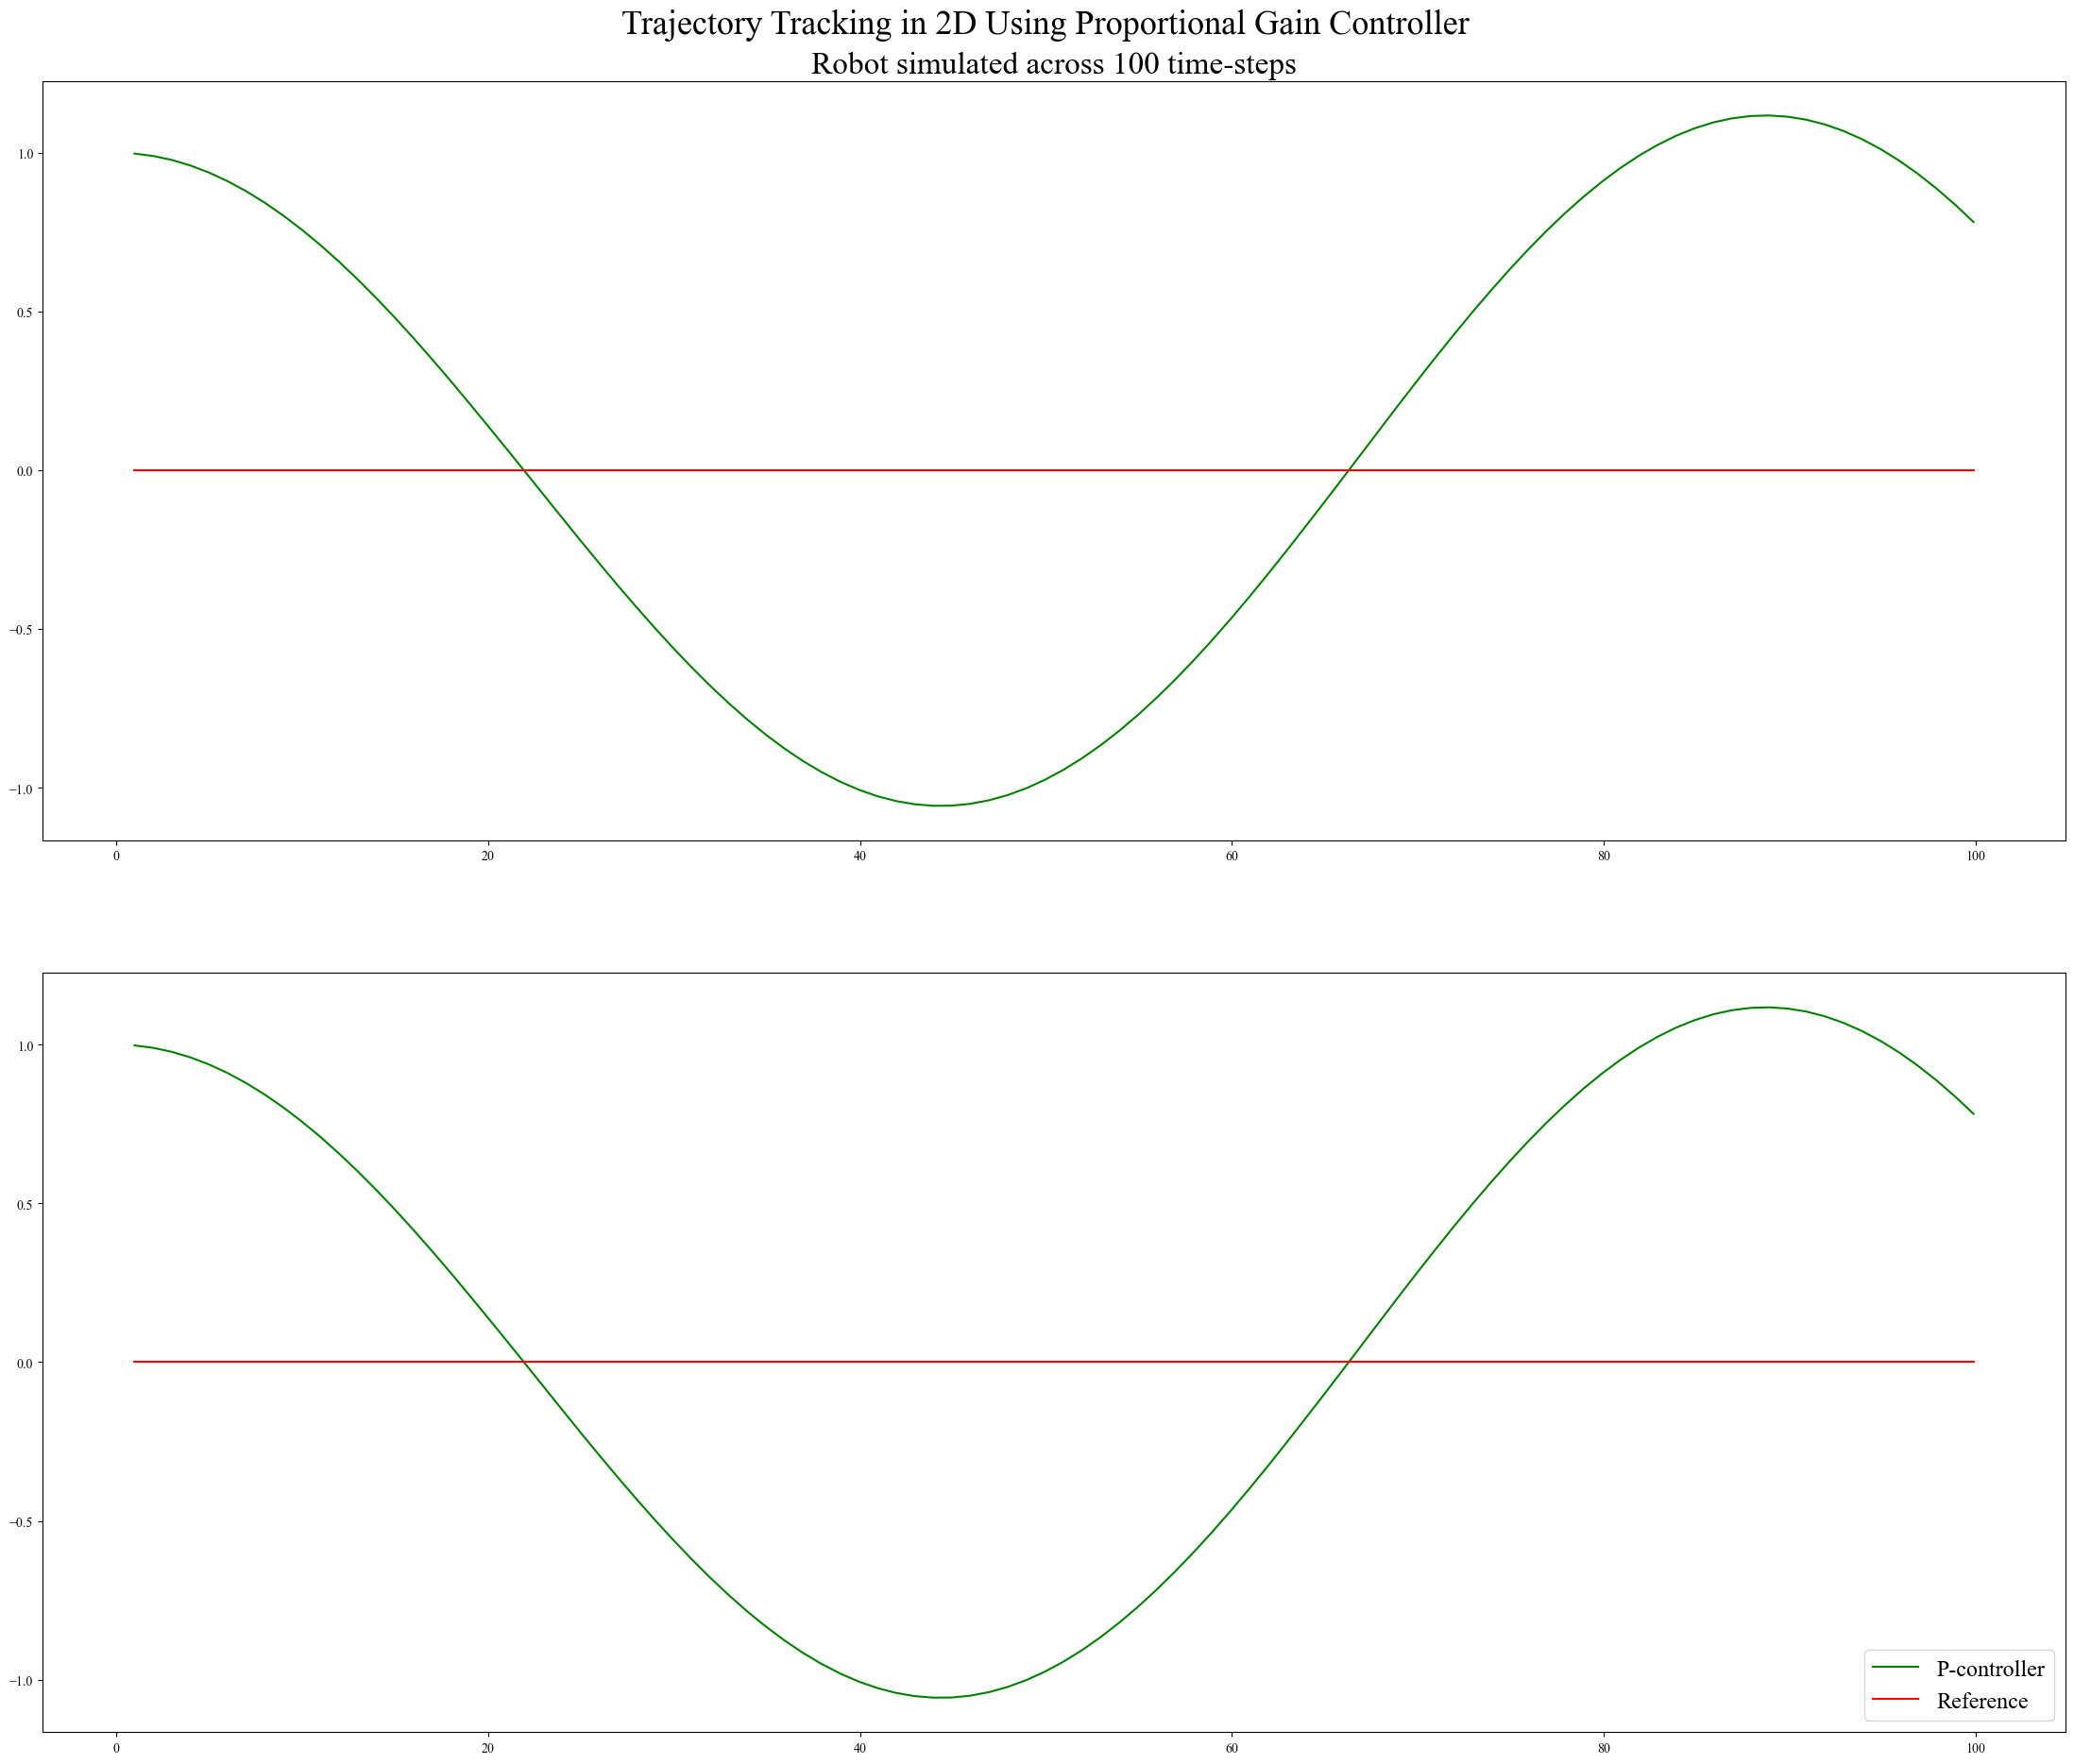

In [8]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(2, 1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
plt.suptitle('Trajectory Tracking in 2D Using Proportional Gain Controller',
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps',
        fontsize=24
)
ax1.plot(x_trajectory, y_trajectory,
        color='g', label='P-controller'
)
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_trajectory, y_trajectory, 
        color='g', label='P-controller'
)
ax2.plot(x_trajectory, np.zeros(len(x_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()

### 2.2. Proportional-Derivative Control

Here we implement the proportional-derivative (PD) controller as defined in the `run_pd` method below.

In [9]:
### From J. Moran's `2_proportional_derivative_control.py`

In [10]:
def run_pd(
        robot: Robot, 
        tau_p: float,
        tau_d: float, 
        n: int=100, 
        speed: float=1.0
) -> Tuple[List[float], List[float]]:
    """Simulates robot movement using proportional-derivative control.

    The proportional-derivative controller used here follows the equation:
        $\alpha = -\tau_{p} * \mathrm{CTE} - \tau_{d} * \Delta \mathrm{CTE}$,
    where the steering input angle $\alpha$ is computed w.r.t. the proportional
    gain controller — i.e., the product of proportional gain $\tau_{p}$ (the
    "response strength") and the current cross-track error $\mathrm{CTE}_{t}$,
    and the derivative of the cross-track error $\Delta \mathrm{CTE}$, i.e., 
        $\frac{\mathrm{CTE}_{t} - \mathrm{CTE}_{t-1}}{\Delta t}$,
    scaled by a constant gain factor $\tau_{d}$. 
    
    Assumed here is a constant unit time-step $\Delta t = 1.0$ and a reference
    trajectory defined as a constant horizontal trajectory about the $x$-axis
    at $y=0$.
    
    The proportional-derivative controller implemented here is used to direct
    the robot motion towards the horizontal reference trajectory by giving
    steering angle commands computed w.r.t. both the normally-distributed
    steering drift and steering-, distance measurement noise.

    :param robot: `Robot` class instance representing the vehicle to manoeuvre. 
    :param tau_p: Proportional gain constant.
    :param tau_d: Anticipatory control constant for derivative control,
        used to control / dampen the influence of the rate-of-error change.
    :param n: Number of time-steps to simulate.
    :param speed: Velocity (m/s) at which to drive the vehicle.
    :returns: Set of x- and y-coordinates of the simulated trajectory.
    """

    # The list of $x$- and $y$-values for the simulated trajectory
    x_trajectory = []
    y_trajectory = []
    # Set the constant unit time-step value (used in derivative term)
    delta_t = 1.0
    # Initialise the "previous" and current cross-track error values
    cte_prev = robot.y
    cte_curr = 0.0
    # Simulate the robot movement across `n` time-steps
    for i in range(n):
        # Get the current cross-track error relative to reference trajectory
        cte_curr = robot.y
        # Compute the steering angle w.r.t. proportional-derivative controller
        # NOTE: `cte_dot` is derivative of CTE w.r.t. constant unit time-step
        cte_dot = (cte_curr - cte_prev) / delta_t
        # Compute the steering angle w.r.t. proportional and derivative gain
        steer = -tau_p * cte_curr - tau_d * cte_dot
        # Set the "previous" CTE value to the current error before manoeuvre
        cte_prev = cte_curr
        # Execute the steering command computed with the PD-controller
        robot.move(steer, speed)
        # Append the updated robot position coordinates to the trajectory lists
        _x, _y = robot.x, robot.y
        x_trajectory.append(_x)
        y_trajectory.append(_y)
    return x_trajectory, y_trajectory

#### Testing the proportional-derivative (PD) controller

Here we compare the performance of the PD controller to the previous proportional-gain controller.

In [11]:
### From J. Moran's `2_proportional_derivative_control.py`

##### Experiment run with the proportional gain controller

In [12]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory first using the proportional-gain controller            
x_p_trajectory, y_p_trajectory = run_p(robot, 0.1)

##### Experiment run with the proportional-derivative controller

In [13]:
 ### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pd(robot, 0.2, 3.0)

##### Plotting and comparing the results

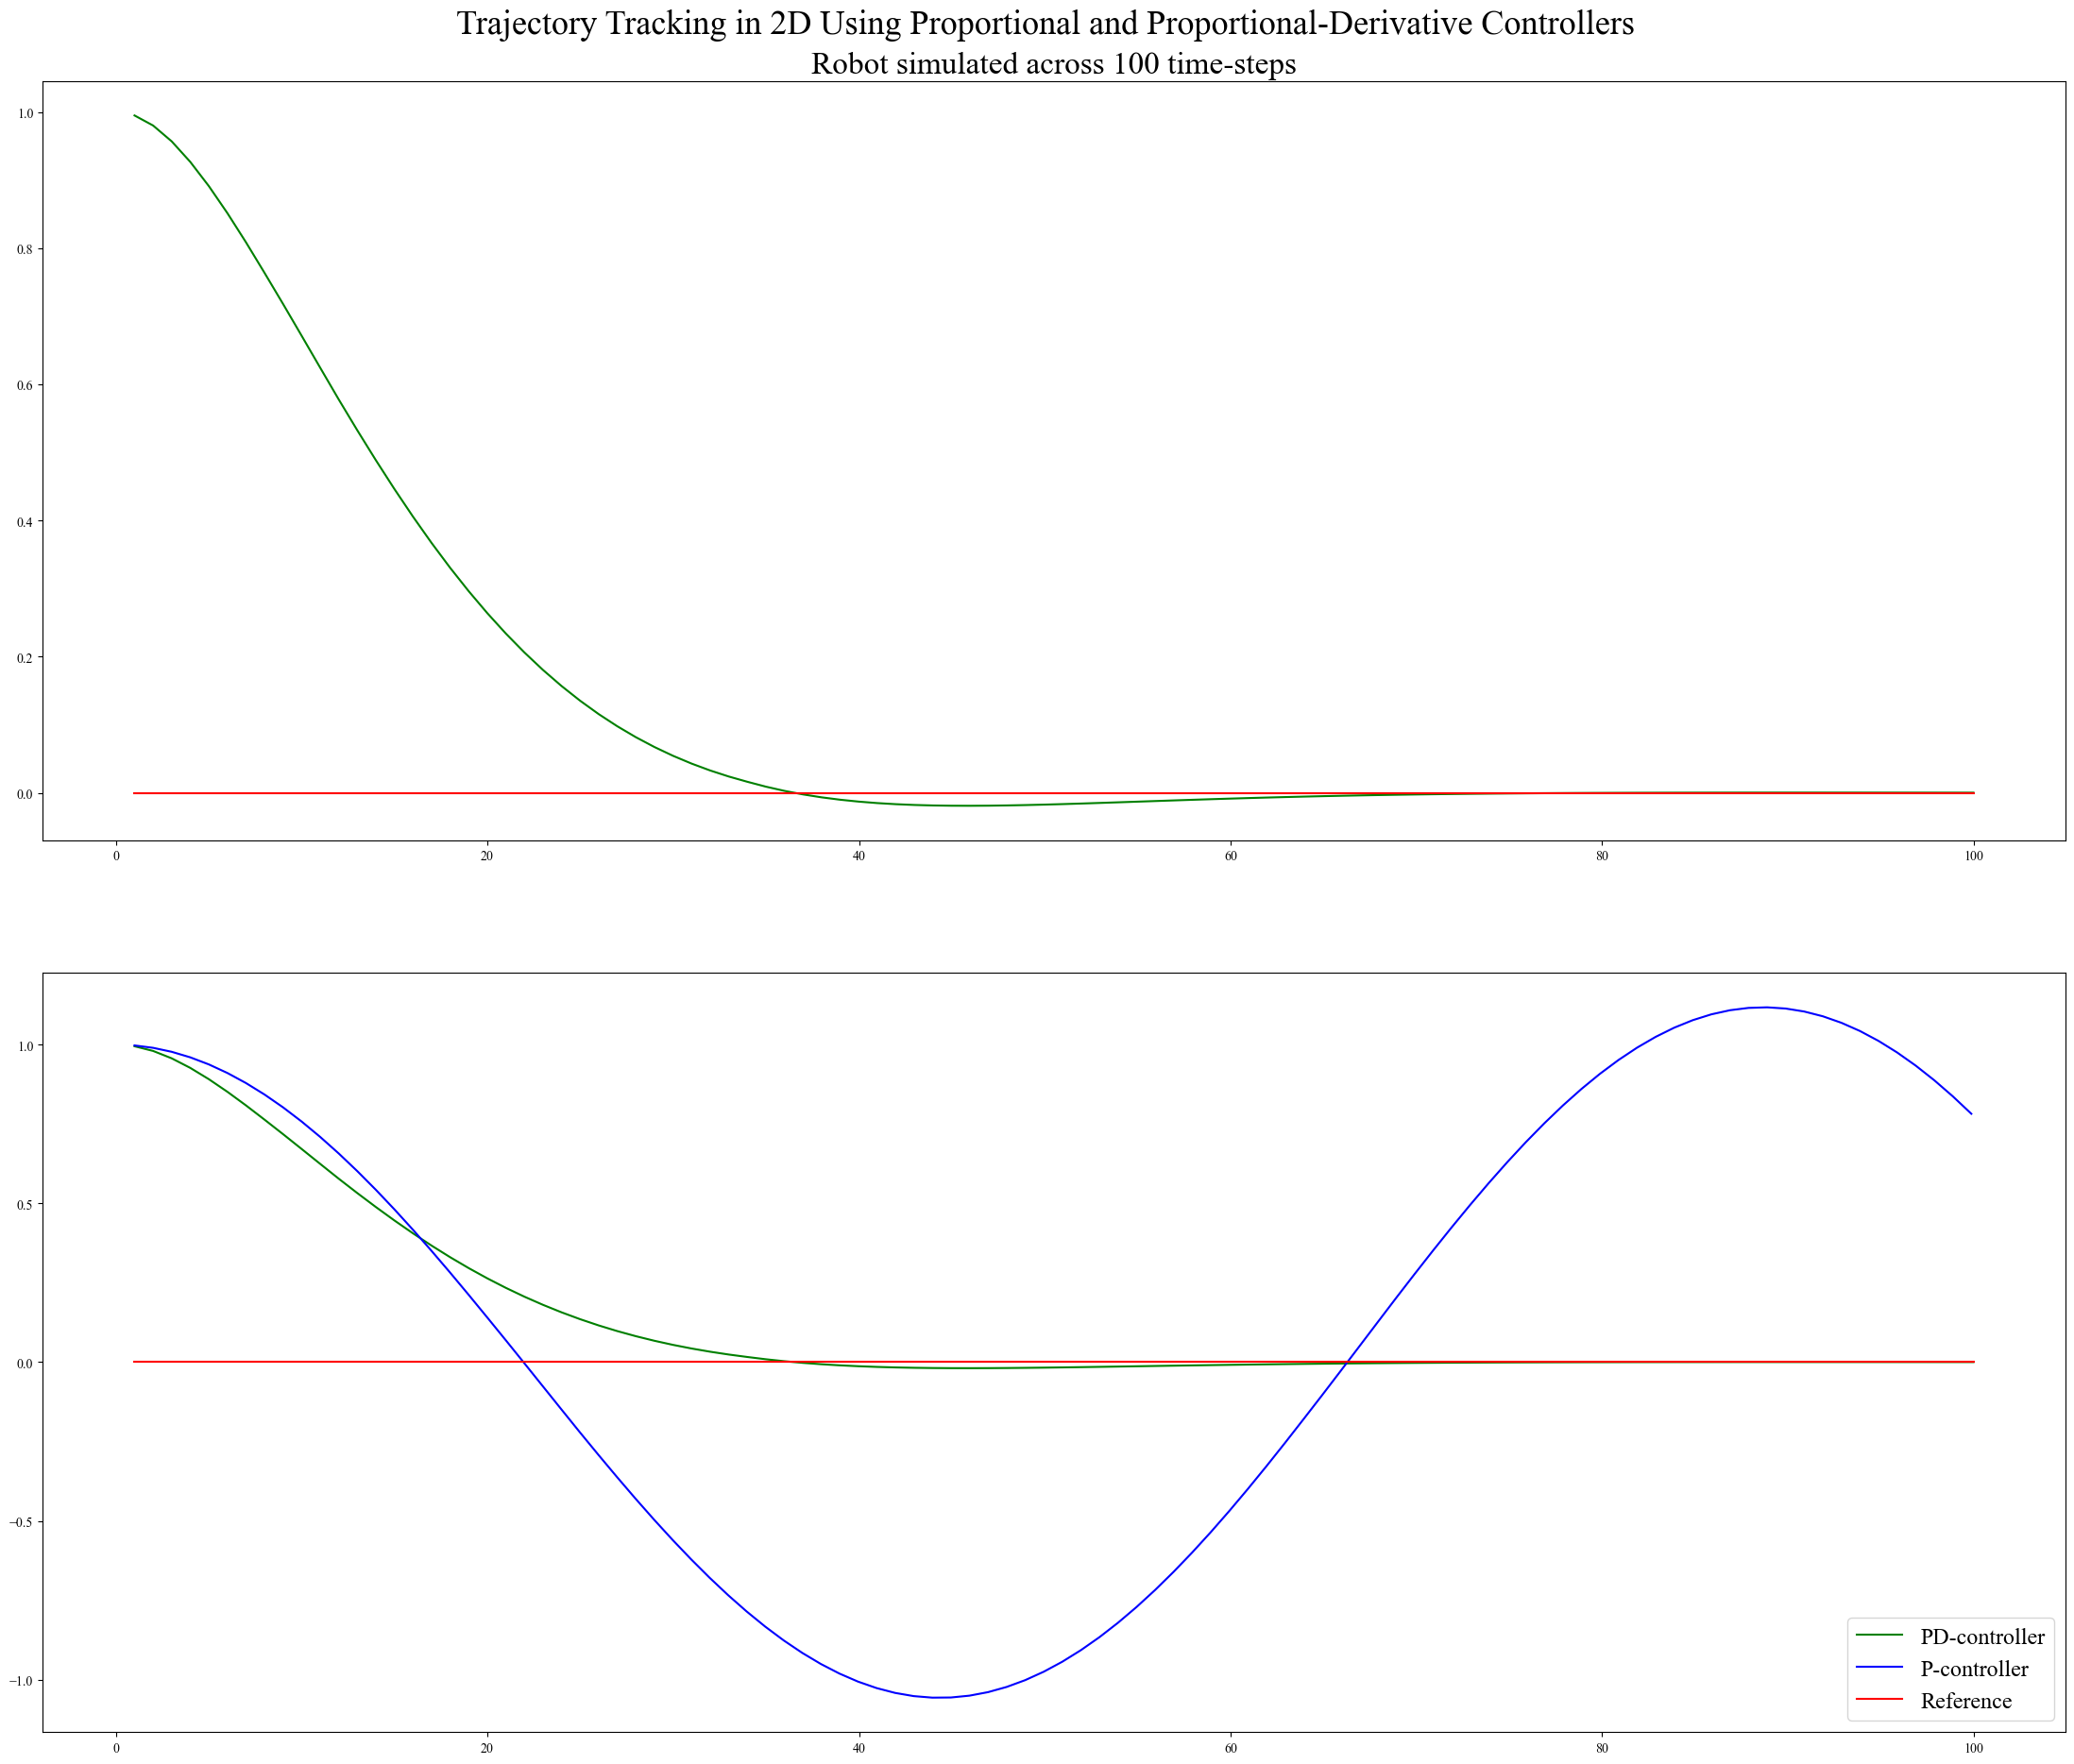

In [14]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
suptxt = 'Trajectory Tracking in 2D Using Proportional and Proportional-Derivative Controllers'
plt.suptitle(suptxt,
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps',
        fontsize=24
)
ax1.plot(x_pd_trajectory, y_pd_trajectory,
        color='g', label='PD-controller'
)
ax1.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_pd_trajectory, y_pd_trajectory, 
        color='g', label='PD-controller'
)
ax2.plot(x_p_trajectory, y_p_trajectory, 
        color='b', label='P-controller'
)
ax2.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()

As shown in the above graph, the PD controller (in green) is able to successfully manoeuvre the robot towards the reference trajectory (in red) with little overshoot. In other words, the robot not only moves more rapidly towards the reference trajectory, but also reaches the goal without tremendous oscillations, as observed with the proportional-gain controller (in blue).

### 2.1.5. Proportional-Derivative Control with Systematic Bias

In this section, we demonstrate the sensitivity of both the proportional-gain and proportional-derivative feedback controllers to _systematic bias_. Here, we observe the effect of introducing a non-ideal _steering angle offset_ into the system and two controllers and examine the resulting stability i.e., the ability of the system to reach an equilibrium point about the desired reference trajectory.

The following demonstrations assume a vehicle steering angle of $10^{\circ}$ offset from the expected value of $0^{\circ}$. After running both the proportional-gain and proportional-derivative feedback controllers as-is, i.e., without any modifications / compensations for this systematic bias, we then observe the controller responses and see how well they fare in reaching the desired reference trajectory.

##### Experiment run with the proportional gain controller

In [15]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)

In [16]:
### NEW: Set the steering drift to an offset of 10 degrees
STEERING_DRIFT_DEG = 10
robot.set_steering_drift(STEERING_DRIFT_DEG * np.pi / 180)

In [17]:
### Execute the trajectory first using the proportional-gain controller            
x_p_trajectory, y_p_trajectory = run_p(robot, 0.1)

##### Experiment run with the proportional-derivative controller

In [18]:
### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

In [19]:
### NEW: Set the steering drift to an offset of 10 degrees
robot.set_steering_drift(STEERING_DRIFT_DEG * np.pi / 180)

In [20]:
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pd(robot, 0.2, 3.0)

##### Plotting and comparing the results

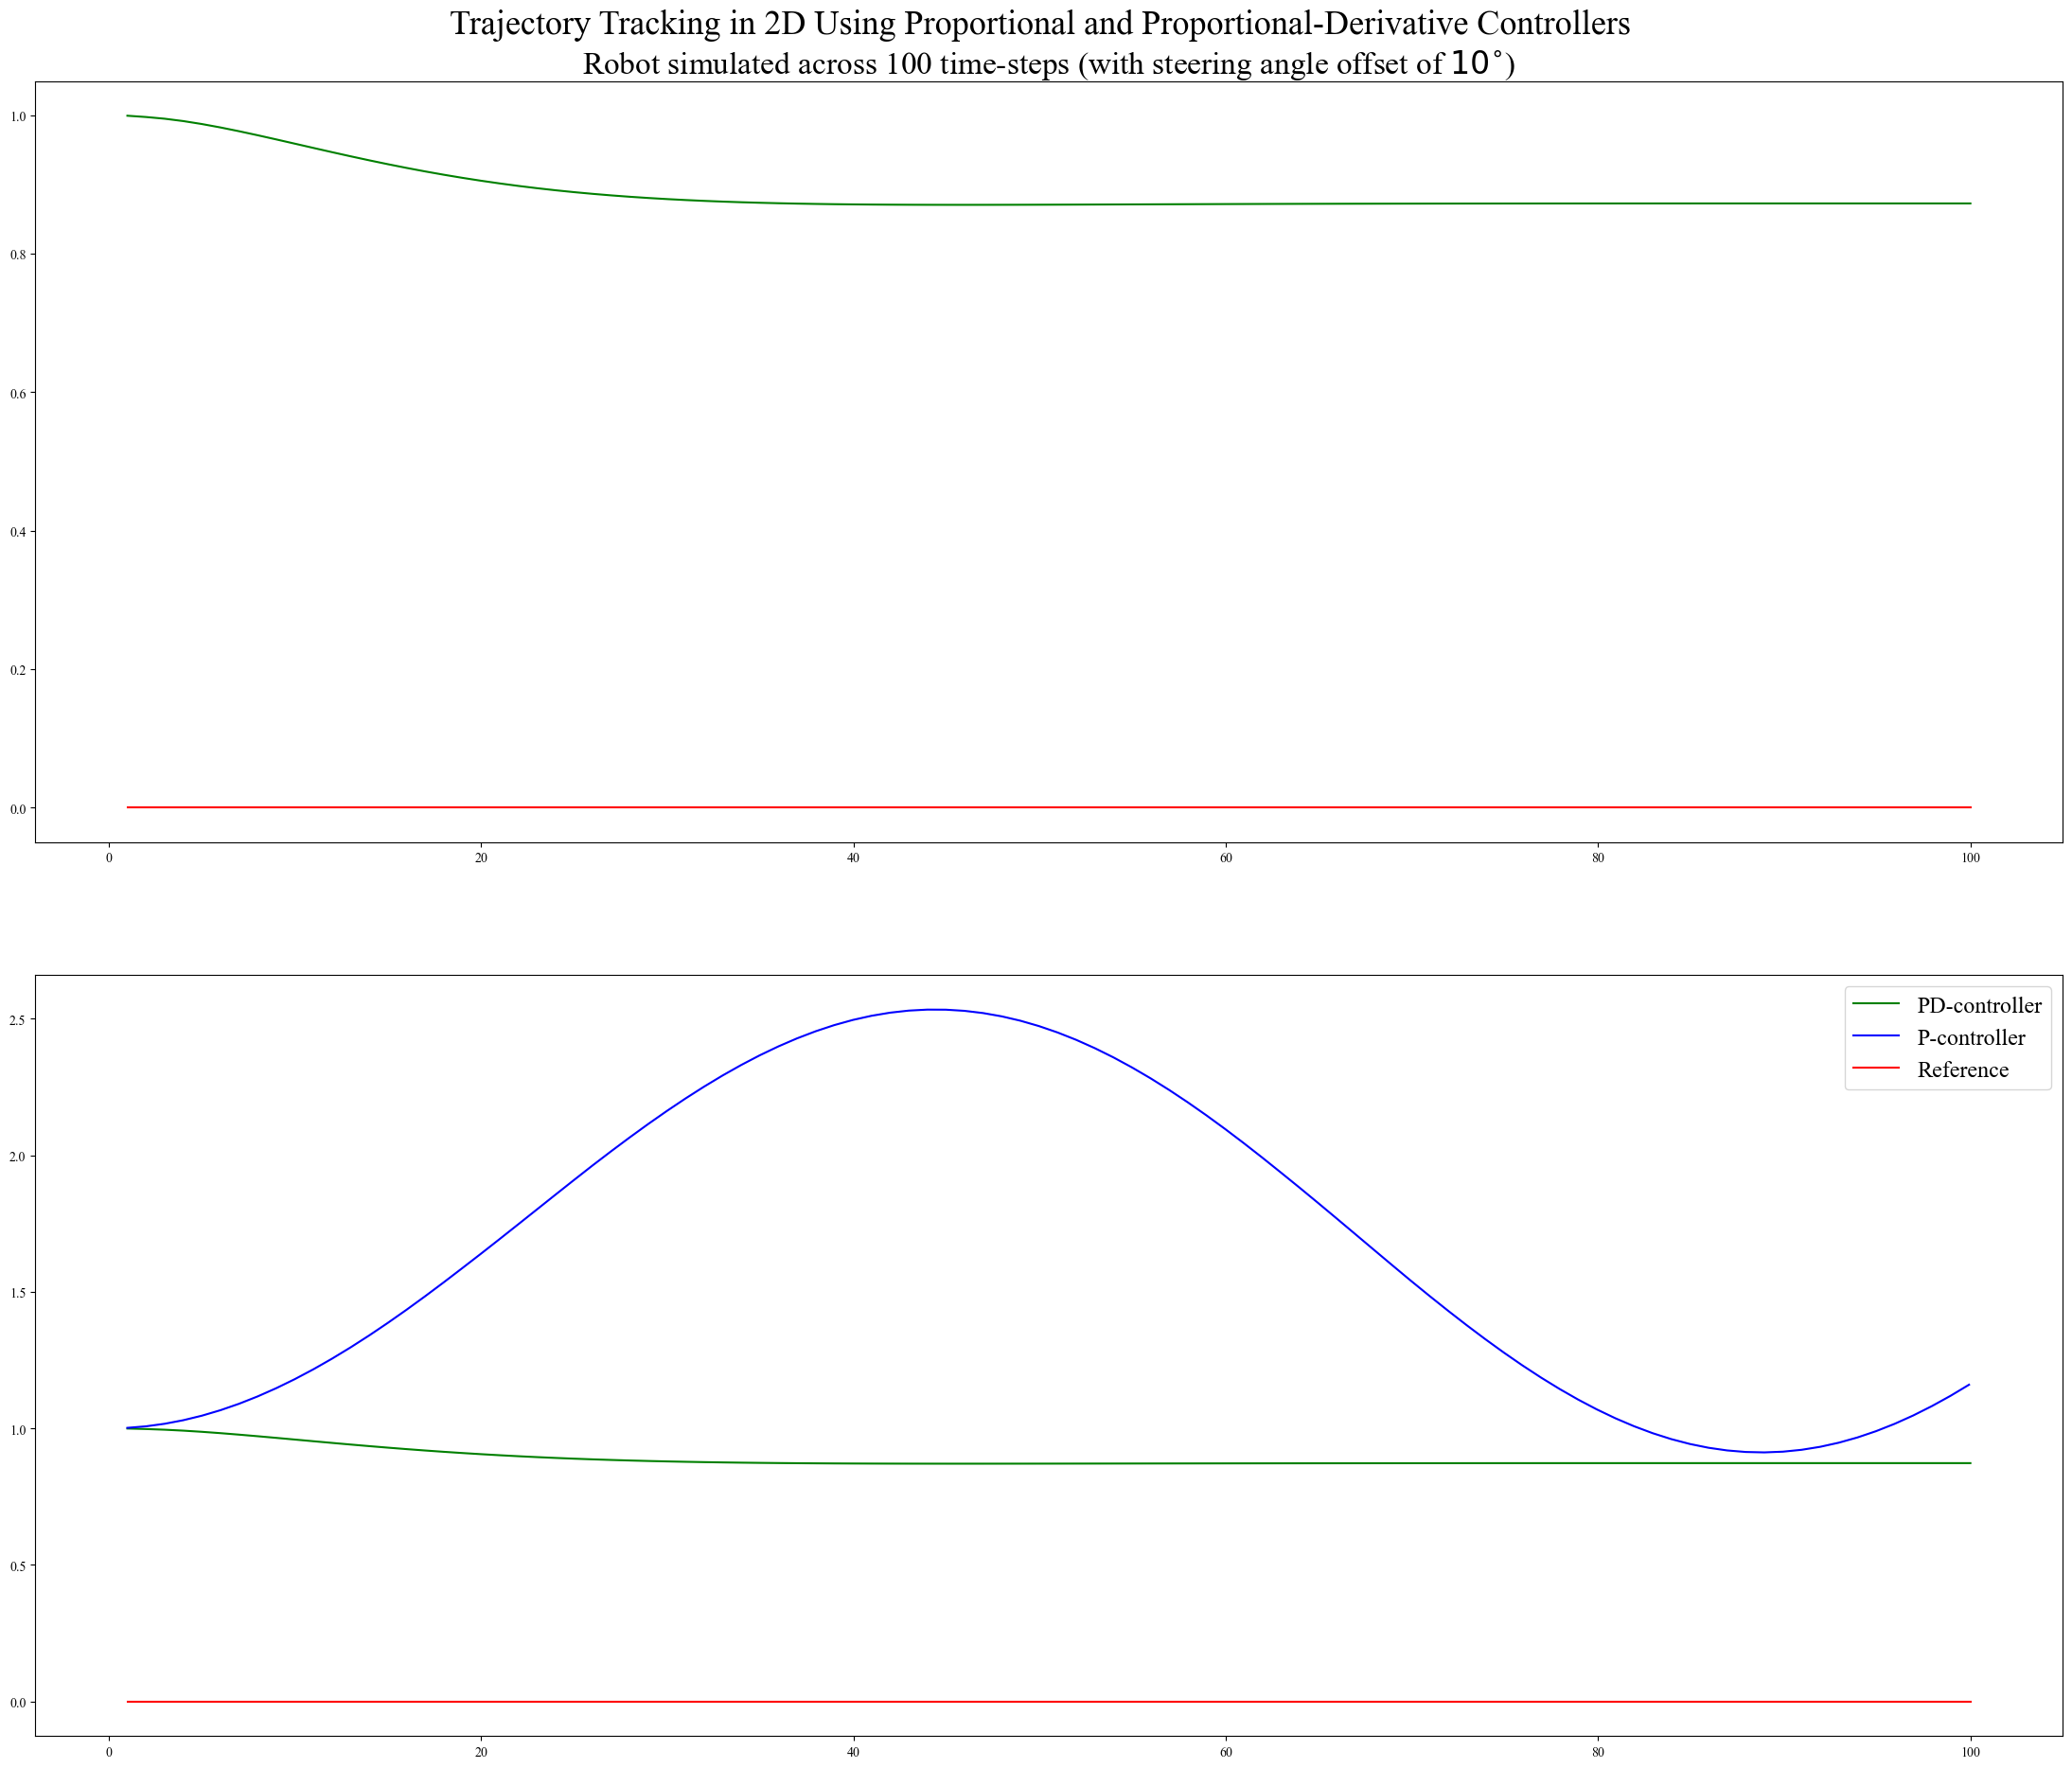

In [21]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
suptxt = 'Trajectory Tracking in 2D Using Proportional and Proportional-Derivative Controllers'
plt.suptitle(suptxt,
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps (with steering angle offset of $10^{\circ}$)',
        fontsize=24
)
ax1.plot(x_pd_trajectory, y_pd_trajectory,
        color='g', label='PD-controller'
)
ax1.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_pd_trajectory, y_pd_trajectory, 
        color='g', label='PD-controller'
)
ax2.plot(x_p_trajectory, y_p_trajectory, 
        color='b', label='P-controller'
)
ax2.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='upper right', fontsize='xx-large')
plt.show()

From the above we observe that both the proportional-gain (blue) and the proportional-derivative (green) controllers fail to steer the vehicle to the desired reference trajectory (red). While the proportional-gain controller exhibits the same oscillatory behaviour as before, the proportional-derivative controller stabilises much more quickly in response to the systematic bias. Ultimately, both controllers fail to achieve desired performance (i.e., reach the reference trajectory) in the expected amount of time.

### 2.3. Proportional-Integral-Derivative (PID) Control

Here we implement the proportional-integral-derivative (PID) controller as defined in the `run_pid` method below.

In [22]:
### From J. Moran's `3_proportional_integral_derivative_control.py`

In [23]:
def run_pid(
        robot: Robot, 
        tau_p: float,
        tau_d: float,
        tau_i: float,
        n: int=100, 
        speed: float=1.0
) -> Tuple[List[float], List[float]]:
    """Simulates robot movement using proportional-integral-derivative control.

    The proportional-integral-derivative controller used here follows:
    $$\begin{align}
    \alpha &= -\tau_{p} * \mathrm{CTE} 
              - \tau_{d} * \Delta \mathrm{CTE} 
              - \tau_{i} * \int_{0}^{t} \mathrm{CTE},
    \end{align}$$
    where the integral-term $\int_{0}^{t} \mathrm{CTE}$ is given as the sum of
    the instantaneous error over time. This gives the accumulated offset that
    should have been previously corrected.

    Assumed here is a constant unit time-step $\Delta t = 1.0$ and a reference
    trajectory defined as a constant horizontal trajectory about the $x$-axis
    at $y=0$.
    
    The proportional-integral-derivative controller implemented here is used
    to direct the robot motion towards the horizontal reference trajectory by
    giving steering angle commands computed w.r.t. both the normally-distributed
    steering drift and steering-, distance measurement noise.

    :param robot: `Robot` class instance representing the vehicle to manoeuvre. 
    :param tau_p: Proportional gain constant.
    :param tau_d: Anticipatory control constant for derivative control,
        used to control / dampen the influence of the rate-of-error change.
    :param tau_i: Sum of instantaneous error over time for integral control,
        used to calculate accumulated error that should have been corrected. 
    :param n: Number of time-steps to simulate.
    :param speed: Velocity (m/s) at which to drive the vehicle.
    :returns: Set of x- and y-coordinates of the simulated trajectory.
    """

    # The list of $x$- and $y$-values for the simulated trajectory
    x_trajectory = []
    y_trajectory = []
    # The list of all previous cross-track errors (used in integral term)
    cte_values = []
    # Set the constant unit time-step value (used in derivative term)
    delta_t = 1.0
    # Initialise the "previous" and current cross-track error values
    cte_prev = robot.y
    cte_curr = 0.0
    # Simulate the robot movement across `n` time-steps
    for i in range(n):
        # Get the current cross-track error relative to reference trajectory
        cte_curr = robot.y
        cte_values.append(cte_curr)
        ### Compute the steering angle w.r.t. PID controller
        # First, caclulate the derivative term
        # NOTE: `cte_dot` is derivative of CTE w.r.t. constant unit time-step
        cte_dot = (cte_curr - cte_prev) / delta_t
        # Then, calculate the integral term 
        cte_int = np.sum(cte_values)
        # Form the expression of the complete PID controller
        # w.r.t. the proportional, integral, and derivative gain values
        steer = -tau_p * cte_curr - tau_d * cte_dot - tau_i * cte_int
        # Set the "previous" CTE value to the current error before manoeuvre
        cte_prev = cte_curr
        # Execute the steering command computed with the PID-controller
        robot.move(steer, speed)
        # Append the updated robot position coordinates to the trajectory lists
        _x, _y = robot.x, robot.y
        x_trajectory.append(_x)
        y_trajectory.append(_y)
    return x_trajectory, y_trajectory

#### Testing the proportional-integral-derivative (PID) controller

Here we evaluate the performance of the PID-controller on robot trajectory tracking. Here, we initialise the robot to a starting position $(0, 1)$ with a heading angle of $0.0$. Just as before, we set the reference trajectory to be situated about the $x$-axis at $y=0$. Using the PID-controller with a set of proportional-, integral-, and derivative-gain values, we compute at each time-step the updated position coordinates with respect to the turning radius as given by the kinematic bicycle motion model.

In [24]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)

##### Experiment run with the proportional gain controller

In [25]:
### Execute the trajectory using the proportional controller            
x_trajectory, y_trajectory = run_p(robot, 0.1)

##### Experiment run with the proportional-derivative controller

In [26]:
 ### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pd(robot, 0.2, 3.0)

##### Experiment run with the proportional-integral-derivative controller

In [27]:
 ### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)
### Execute the trajectory using the proportional-derivative controller            
x_pid_trajectory, y_pid_trajectory = run_pid(robot, 0.2, 3.0, 0.004)

##### Plotting and comparing the results

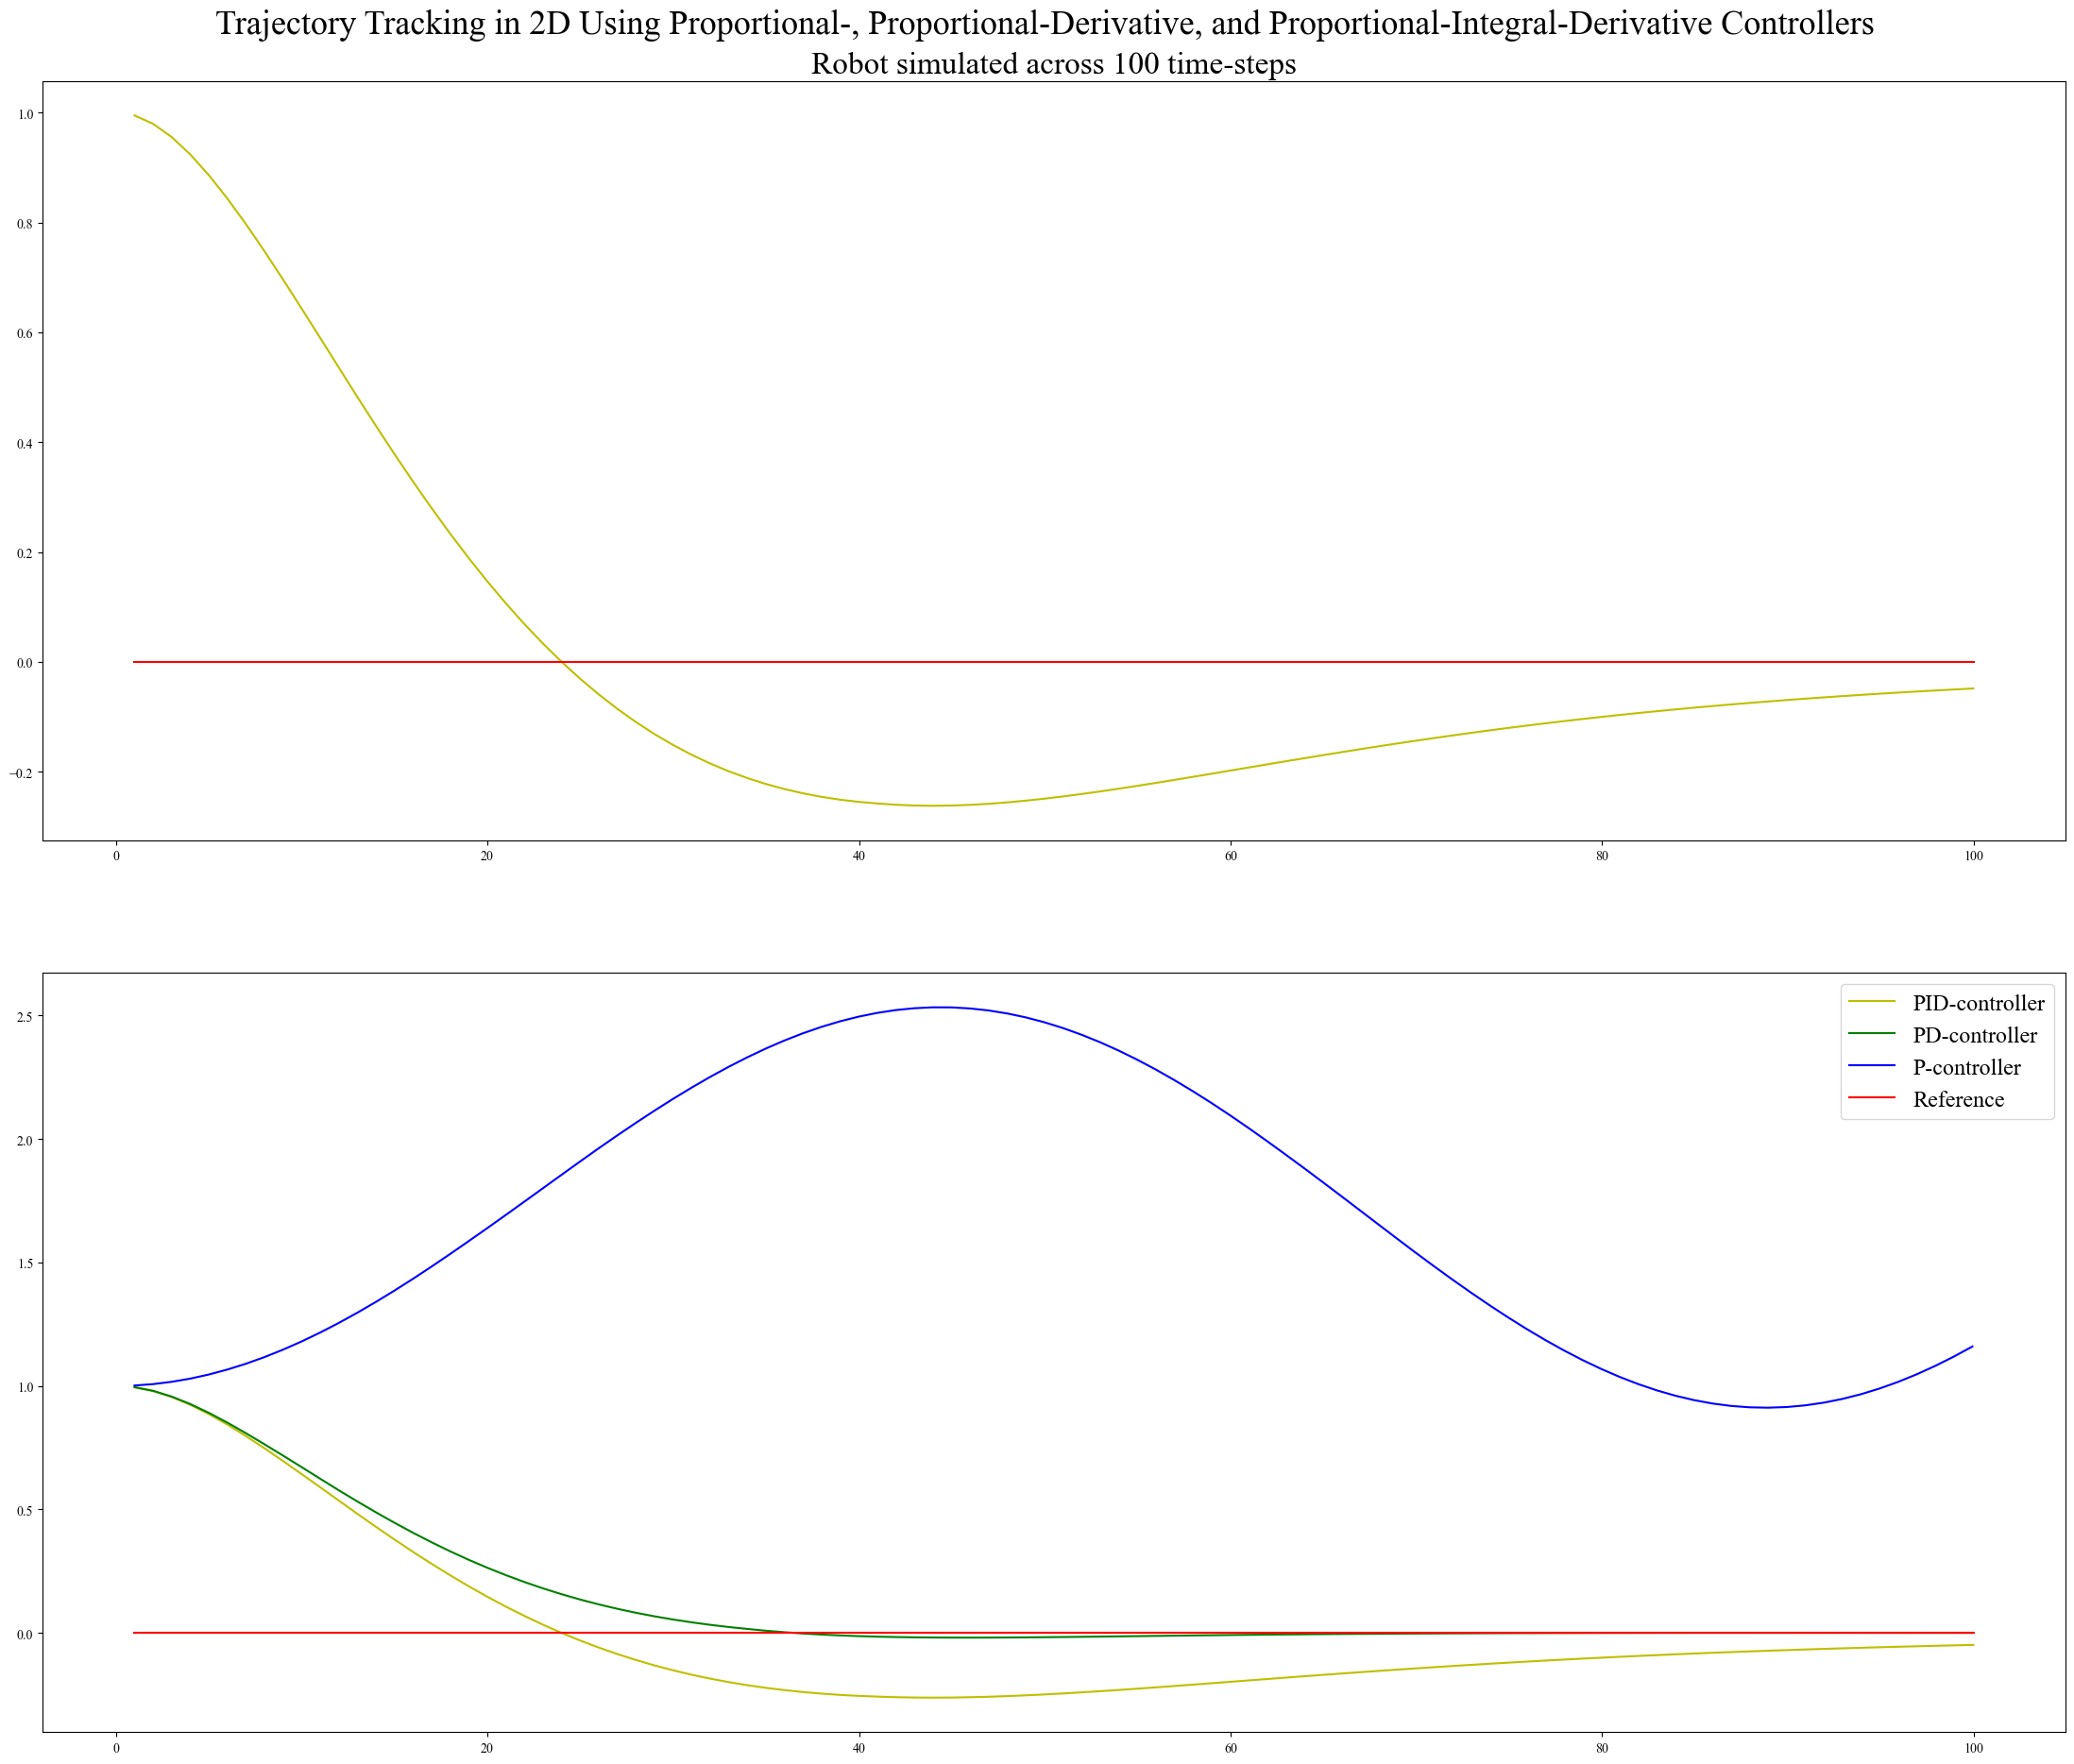

In [28]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
suptxt = 'Trajectory Tracking in 2D Using Proportional-, '
suptxt += 'Proportional-Derivative, and Proportional-Integral-Derivative Controllers'
plt.suptitle(suptxt,
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps',
        fontsize=24
)
ax1.plot(x_pid_trajectory, y_pid_trajectory,
        color='y', label='PID-controller'
)
ax1.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_pid_trajectory, y_pid_trajectory, 
        color='y', label='PID-controller'
)
ax2.plot(x_pd_trajectory, y_pd_trajectory, 
        color='g', label='PD-controller'
)
ax2.plot(x_p_trajectory, y_p_trajectory, 
        color='b', label='P-controller'
)
ax2.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='upper right', fontsize='xx-large')
plt.show()

In the figure above we see that the robot with the PID-controller (yellow) was able to successfully track the reference trajectory within reason. In this specific case, we notice that the PID-controller does not track exactly the reference trajectory — as is the case with the PD-controller (green). The integral term of the PID-controller is used to compensate for accumulated error due to e.g., systematic bias. Since in this experiment we do _not_ introduce any bias, it should not be alarming that the PID-controller in its current state is performing poorly relative to the PD-controller. 

In the next section we will see how the PID-controller fares when the same steering offset from Sect. 2.2.5 is added.   

### 2.3.5. Proportional-Integral-Derivative (PID) Control with Systematic Bias

Using the same PID-controller we designed in the previous section, we now test the performance of the PID-controller in the 2D robot trajectory tracking task. This time, we add a _steering offset_ of $10^{\circ}$ to the robot. This will act as a systematic bias and, without proper compensation, will compromise the ability of the controller to properly manoeuvre the robot to the goal reference trajectory. 

##### Experiment run with the proportional gain controller

In [29]:
### Initialise the robot instance using default values
robot = Robot()
### Perform a single control run to position (0, 1)
# with heading angle `0.0`
robot.set(0.0, 1.0, 0.0)

In [30]:
### NEW: Set the steering drift to an offset of 10 degrees
STEERING_DRIFT_DEG = 10
robot.set_steering_drift(STEERING_DRIFT_DEG * np.pi / 180)

In [31]:
### Execute the trajectory first using the proportional-gain controller            
x_p_trajectory, y_p_trajectory = run_p(robot, 0.1)

##### Experiment run with the proportional-derivative controller

In [32]:
### Re-initialise the robot to the starting PD-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

In [33]:
### NEW: Set the steering drift to an offset of 10 degrees
robot.set_steering_drift(STEERING_DRIFT_DEG * np.pi / 180)

In [34]:
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pd(robot, 0.2, 3.0)

##### Experiment run with the proportional-integral-derivative controller

In [35]:
### Re-initialise the robot to the starting PID-controller run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

In [36]:
### NEW: Set the steering drift to an offset of 10 degrees
robot.set_steering_drift(STEERING_DRIFT_DEG * np.pi / 180)

In [37]:
### Execute the trajectory using the proportional-derivative controller            
x_pd_trajectory, y_pd_trajectory = run_pid(robot, 0.2, 3.0, 0.004)

##### Plotting and comparing the results

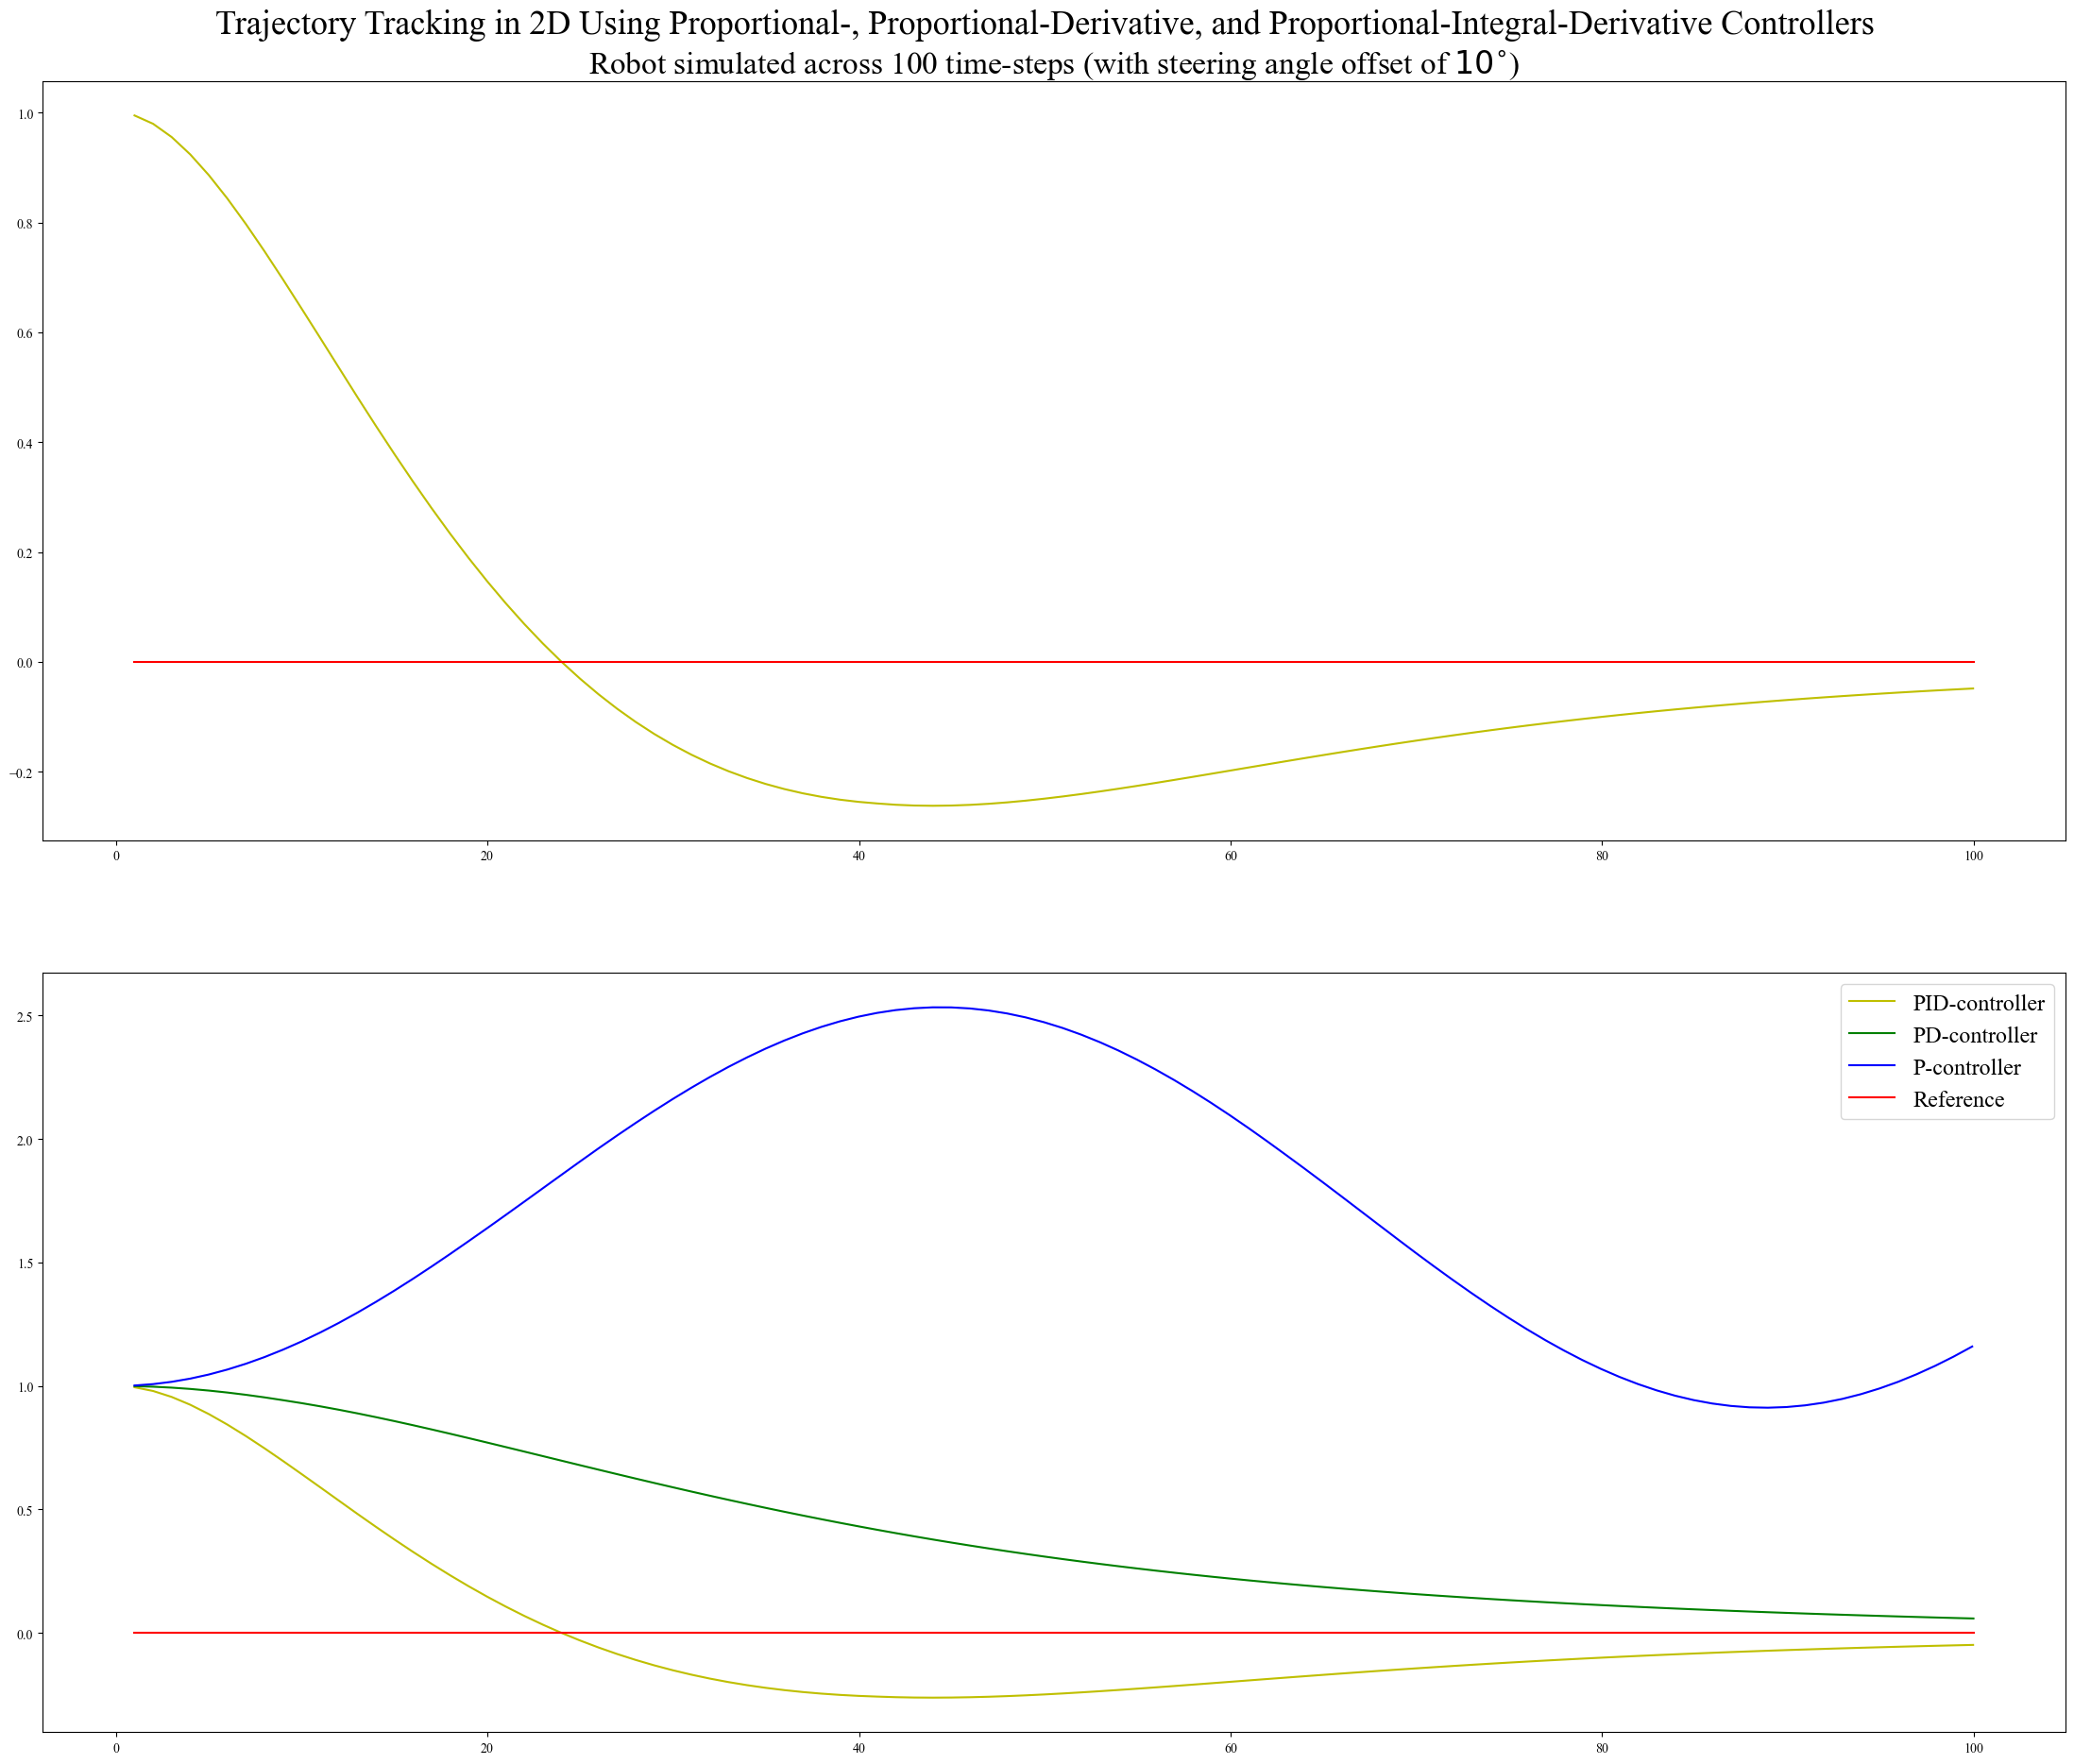

In [38]:
### Plot the robot position and orientation relative to the reference
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
        figsize=(24, 20)
)
plt.tight_layout(pad=8.0)
suptxt = 'Trajectory Tracking in 2D Using Proportional-, '
suptxt += 'Proportional-Derivative, and Proportional-Integral-Derivative Controllers'
plt.suptitle(suptxt,
        fontsize=26
)
ax1.set_title('Robot simulated across 100 time-steps (with steering angle offset of $10^{\circ}$)',
        fontsize=24
)
ax1.plot(x_pid_trajectory, y_pid_trajectory,
        color='y', label='PID-controller'
)
ax1.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)),
        color='r', label='Reference'
)
ax2.plot(x_pid_trajectory, y_pid_trajectory, 
        color='y', label='PID-controller'
)
ax2.plot(x_pd_trajectory, y_pd_trajectory, 
        color='g', label='PD-controller'
)
ax2.plot(x_p_trajectory, y_p_trajectory, 
        color='b', label='P-controller'
)
ax2.plot(x_pd_trajectory, np.zeros(len(x_pd_trajectory)), 
        color='r', label='Reference'
)
plt.legend(loc='upper right', fontsize='xx-large')
plt.show()

## 3. Closing Remarks

##### Alternatives
* TODO.

##### Extensions of task
* TODO.

## 4. Future Work
* ⬜️ TODO.

## Credits

This assignment was prepared by Sebastian Thrun, 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).

References
* Ziegler, J.G., Nichols, N.B. Optimum Settings for Automatic Controllers. Transactions of the ASME, 64(1): 759-768. 1942. [doi:10.1115/1.2899060](https://doi.org/10.1115/1.2899060).
* Åström, K. J., Hägglund, T. Automatic Tuning of Simple Regulators with Specifications on Phase and Amplitude Margins. Automatica, 20(5):645-651. 1984. [doi:10.1016/0005-1098(84)90014-1](https://doi.org/10.1016/0005-1098(84)90014-1).
* Cohen, G. H., Coon, G. A. Theoretical Consideration of Retarded Control. Transactions of the ASME, 75(1):827-834. 1953. [doi:10.1115/1.4015451](https://doi.org/10.1115/1.4015451).

Helpful resources:
* [Simple Understanding of Kinematic Bicycle Model by Y. Ding | Medium](https://dingyan89.medium.com/simple-understanding-of-kinematic-bicycle-model-81cac6420357);
* [Proportional-only Control in Ch. 32 — Closed-loop Control Systems | Control Automation](https://control.com/textbook/closed-loop-control/proportional-only-control/);
* [Derivative (Rate) Control in Ch. 32 — Closed-loop Control Systems | Control Automation](https://control.com/textbook/closed-loop-control/derivative-rate-control/);
* [Fundamentals of Linear Control: A Concise Approach, 1/e, by Mauricio C. de Oliviera (2017), ISBN-10:1107187524 or ISBN-13:9781107187528](https://assets.cambridge.org/97811071/87528/frontmatter/9781107187528_frontmatter.pdf) — a fantastic read from UCSD's best professor 😊;
* [MAE143B: Linear Control by @jonathanloganmoran | GitHub repository](https://github.com/jonathanloganmoran/MAE143B-Linear-Control) — the companion code to the [MAE143B course](https://guitar.ucsd.edu/mauricio/courses/mae143b/index.html) in Linear Control taught by Prof. Mauricio C. de Oliviera;
* [A Review of Relay Auto-tuning Methods for the Tuning of PID-type Controllers by S. Hornsey | IATL Vol. 5(2) Archive](https://warwick.ac.uk/fac/cross_fac/iatl/reinvention/archive/volume5issue2/hornsey/);
* [PID Tuning via Classical Methods in Chemical Process Dynamics and Controls (Wolf) | LibreTexts Engineering](https://eng.libretexts.org/Bookshelves/Industrial_and_Systems_Engineering/Book%3A_Chemical_Process_Dynamics_and_Controls_(Woolf)/09%3A_Proportional-Integral-Derivative_(PID)_Control/9.03%3A_PID_Tuning_via_Classical_Methods);